In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [3]:
from data.datasets.random_dataset import RandomDataset
from data.datasets.golden_panels import GoldenPanelsDataset
from data.augment import get_PIL_image

from networks.ssupervae_intro import IntroSSuperVAE
from training.intro_ssupervae_trainer import IntroSSuperVAETrainer
from utils.config_utils import read_config, Config
from utils.logging_utils import *
from utils.plot_utils import *
from utils import pytorch_util as ptu

from configs.base_config import *
from functional.losses.elbo import elbo

In [22]:
config = read_config(Config.SSUPERVAE_INTRO)
golden_age_config = read_config(Config.GOLDEN_AGE)
ptu.set_gpu_mode(True)

In [5]:
net = IntroSSuperVAE(config.backbone,
                    latent_dim=config.latent_dim,
                    embed_dim=config.embed_dim,
                    use_lstm=config.use_lstm,
                    seq_size=config.seq_size,
                    face_encoder_decoder_channels=config.face_encoder_decoder_channels,
                    gen_img_size=config.image_dim,
                    lstm_hidden=config.lstm_hidden,
                    lstm_dropout=config.lstm_dropout,
                    fc_hidden_dims=config.fc_hidden_dims,
                    fc_dropout=config.fc_dropout,
                    num_lstm_layers=config.num_lstm_layers,
                    masked_first=config.masked_first).to(ptu.device)
load_path = "checkpoints/plain_ssupervae_model-checkpoint-epoch20.pth"
net.load_state_dict(torch.load(load_path)['model_state_dict'])
net = net.cuda().eval()

Loaded pretrained weights for efficientnet-b5


In [28]:
limit_size=2048
data = GoldenPanelsDataset(golden_age_config.panel_path,
                               golden_age_config.sequence_path,
                               golden_age_config.panel_dim,
                               config.image_dim,
                               augment=False,
                                mask_val=1, # mask with white color for 1 and black color for 0
                                  mask_all=False, # masks faces from all panels and returns all faces
                                  return_mask=True,
                                  train_test_ratio=golden_age_config.train_test_ratio,
                              train_mode=False,
                              limit_size=limit_size)

In [29]:
data_loader = DataLoader(data, batch_size=1, shuffle=True, num_workers=4)

In [30]:
dl_iter = iter(data_loader)

## Masking Test

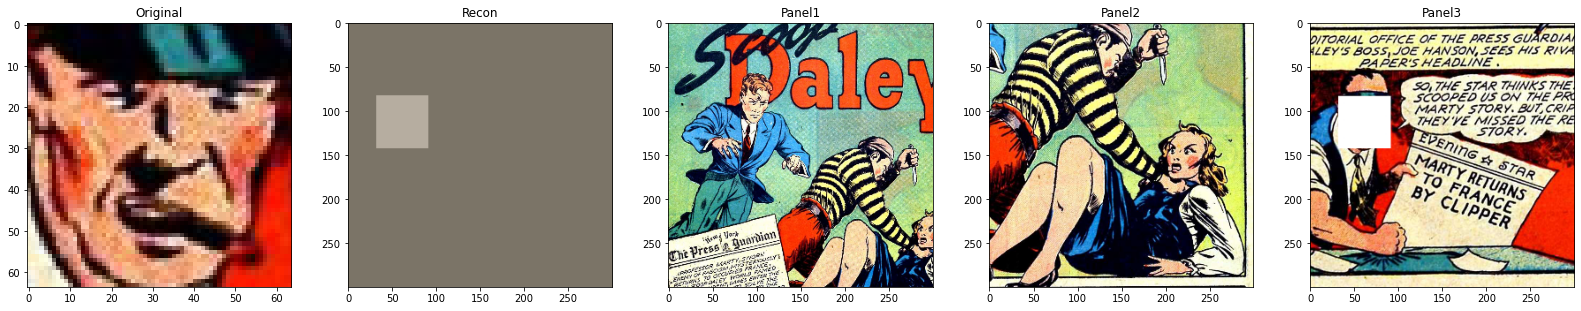

In [31]:
x, y, z = next(dl_iter)
plot_panels_and_faces(x, y, z.unsqueeze(0).repeat(1, 3, 1, 1))

## Model Result Test

[INFO] Example: 0


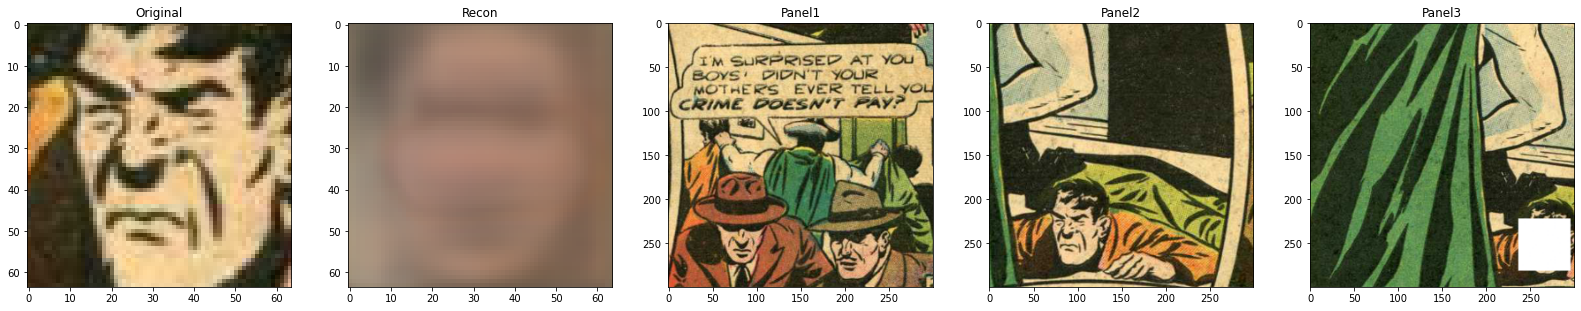

[INFO] Example: 1


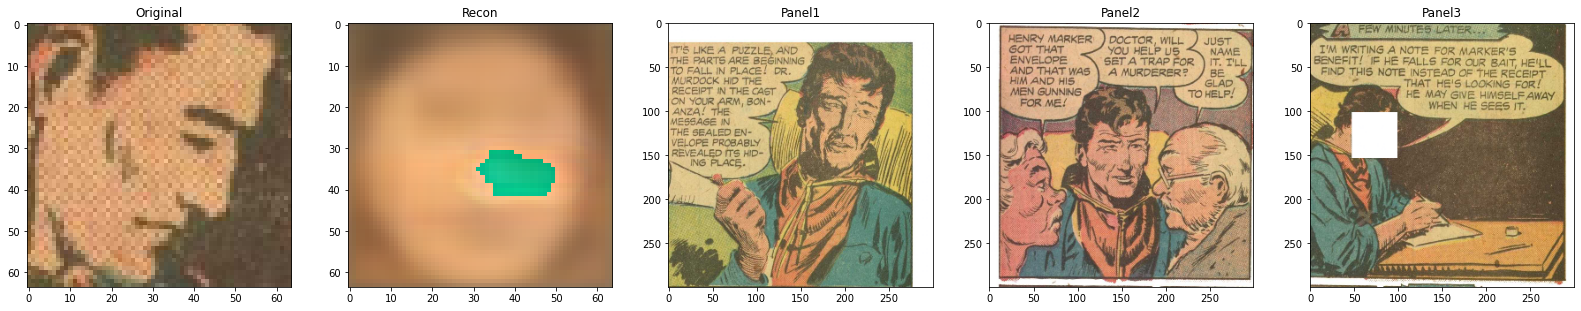

[INFO] Example: 2


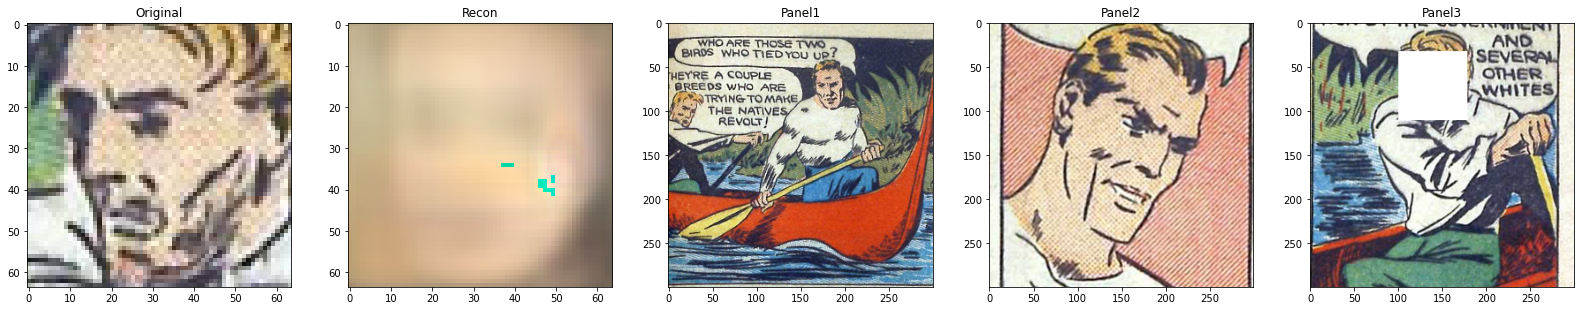

In [34]:
ctr, limit = 0, 3

for i in range(limit):
    x, y, z = next(dl_iter)
    
    with torch.no_grad():
        _, _, _, y_recon, _ = net(x.cuda())   
    print("[INFO] Example:", i)
    plot_panels_and_faces(x, y, y_recon.cpu())